# Transfer learning and fine-tuning
Name: Tasfiha Saba 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, I will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. 

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 2s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

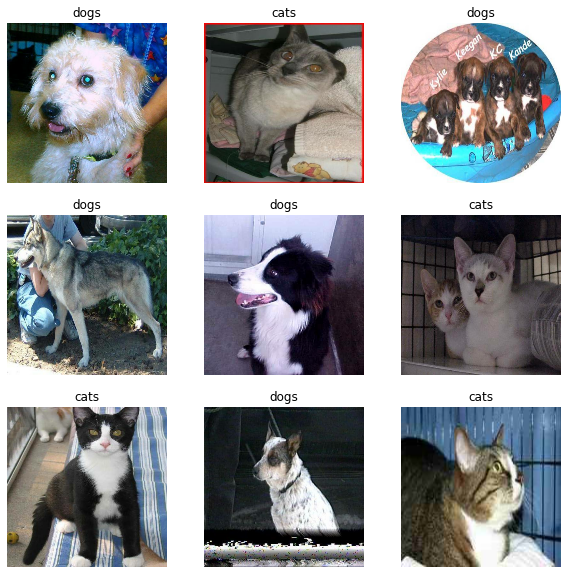

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, I will create one. To do so, I will determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

I will use buffered prefetching to load images from disk without having I/O become blocking. 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Going to repeatedly apply these layers to the same image and see the result.

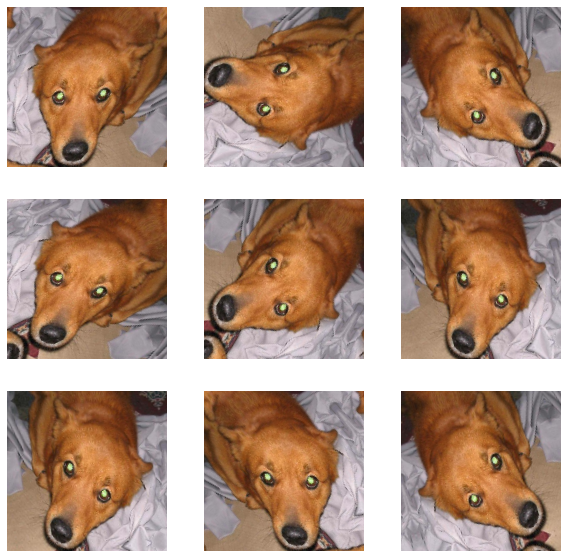

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, I will download `tf.keras.applications.MobileNetV2` to use as my base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in images are in `[0, 255]`. To rescale them, I will use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Create the base model from the pre-trained convnets
I will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, I wiil pick which layer of MobileNet V2 I will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, I will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, I will load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, I will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, I will add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before I compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Applying a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. We don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, I will use `training=False` as our model contains a `BatchNormalization` layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, I will use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 43ms/step - loss: 0.7091 - accuracy: 0.5495


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.55


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 10s 99ms/step - loss: 0.6861 - accuracy: 0.5700 - val_loss: 0.4974 - val_accuracy: 0.6733
Epoch 2/10
63/63 [==============================] - 5s 83ms/step - loss: 0.5238 - accuracy: 0.6780 - val_loss: 0.3623 - val_accuracy: 0.8094
Epoch 3/10
63/63 [==============================] - 5s 78ms/step - loss: 0.4234 - accuracy: 0.7725 - val_loss: 0.2929 - val_accuracy: 0.8614
Epoch 4/10
63/63 [==============================] - 5s 79ms/step - loss: 0.3548 - accuracy: 0.8240 - val_loss: 0.2402 - val_accuracy: 0.8849
Epoch 5/10
63/63 [==============================] - 5s 81ms/step - loss: 0.3140 - accuracy: 0.8555 - val_loss: 0.2095 - val_accuracy: 0.9022
Epoch 6/10
63/63 [==============================] - 5s 79ms/step - loss: 0.2798 - accuracy: 0.8700 - val_loss: 0.1820 - val_accuracy: 0.9146
Epoch 7/10
63/63 [==============================] - 5s 80ms/step - loss: 0.2552 - accuracy: 0.8940 - val_loss: 0.1593 - val_accuracy: 0.9319
Epoch 8/10
6

# Custom model

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model_custom = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model_custom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_custom = model_custom.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 94ms/step - loss: 0.3513 - accuracy: 0.8320 - val_loss: 0.1036 - val_accuracy: 0.9728
Epoch 2/10
63/63 [==============================] - 5s 81ms/step - loss: 0.1616 - accuracy: 0.9360 - val_loss: 0.0646 - val_accuracy: 0.9827
Epoch 3/10
63/63 [==============================] - 5s 80ms/step - loss: 0.1246 - accuracy: 0.9435 - val_loss: 0.0547 - val_accuracy: 0.9839
Epoch 4/10
63/63 [==============================] - 6s 91ms/step - loss: 0.1218 - accuracy: 0.9485 - val_loss: 0.0500 - val_accuracy: 0.9876
Epoch 5/10
63/63 [==============================] - 5s 80ms/step - loss: 0.0973 - accuracy: 0.9635 - val_loss: 0.0486 - val_accuracy: 0.9839
Epoch 6/10
63/63 [==============================] - 5s 80ms/step - loss: 0.0951 - accuracy: 0.9635 - val_loss: 0.0462 - val_accuracy: 0.9814
Epoch 7/10
63/63 [==============================] - 5s 79ms/step - loss: 0.0954 - accuracy: 0.9620 - val_loss: 0.0521 - val_accuracy: 0.9765
Epoch 8/10
63

#### **=> We build custom model by adding more 3 dense layers256, 128, 128 with activation relu. Custom model archive 0.98 accuracy from epoch 3, it's better than previous model. Because dense layer help model extract more features in images to improve accuracy.**

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

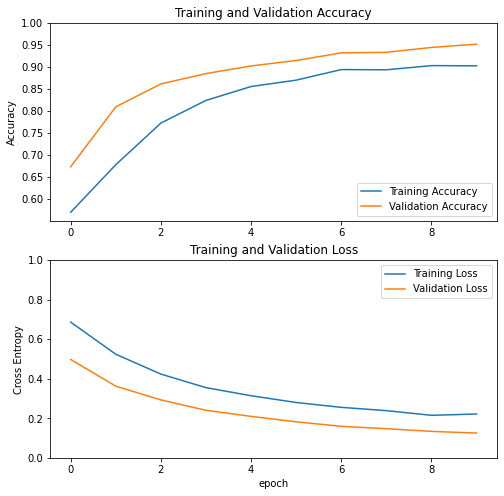

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

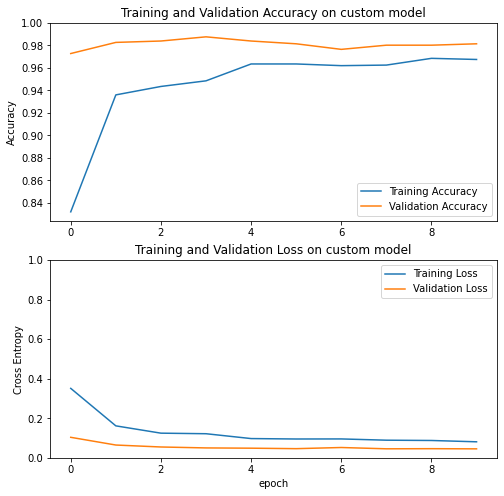

In [ ]:
acc_custom = history_custom.history['accuracy']
val_acc_custom = history_custom.history['val_accuracy']

loss_custom = history_custom.history['loss']
val_loss_custom = history_custom.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_custom, label='Training Accuracy')
plt.plot(val_acc_custom, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy on custom model')

plt.subplot(2, 1, 2)
plt.plot(loss_custom, label='Training Loss')
plt.plot(val_loss_custom, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss on custom model')
plt.xlabel('epoch')
plt.show()

Note: The validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, I will be only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier I added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after I have trained the top-level classifier with the pre-trained model set to non-trainable. If I add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and my pre-trained model will forget what it has learned.

Also, I will try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As I go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All I need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, I will recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As I'm training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, my model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

### Continue training the model

This step will improve my accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 12s 102ms/step - loss: 0.1546 - accuracy: 0.9330 - val_loss: 0.0585 - val_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 6s 94ms/step - loss: 0.1198 - accuracy: 0.9520 - val_loss: 0.0536 - val_accuracy: 0.9728
Epoch 12/20
63/63 [==============================] - 6s 89ms/step - loss: 0.1128 - accuracy: 0.9520 - val_loss: 0.0421 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 6s 90ms/step - loss: 0.0784 - accuracy: 0.9655 - val_loss: 0.0464 - val_accuracy: 0.9889
Epoch 14/20
63/63 [==============================] - 6s 89ms/step - loss: 0.0795 - accuracy: 0.9630 - val_loss: 0.0325 - val_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 8s 120ms/step - loss: 0.0871 - accuracy: 0.9630 - val_loss: 0.0304 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 6s 90ms/step - loss: 0.0781 - accuracy: 0.9705 - val_loss: 0.0530 - val_accuracy: 0.9703
Epo

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so I might get some overfitting.

I might also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


# Custom model

In [ ]:
model_custom.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

history_fine_custom = model_custom.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 11s 105ms/step - loss: 0.0746 - accuracy: 0.9775 - val_loss: 0.0580 - val_accuracy: 0.9765
Epoch 11/20
63/63 [==============================] - 6s 94ms/step - loss: 0.0542 - accuracy: 0.9810 - val_loss: 0.0431 - val_accuracy: 0.9790
Epoch 12/20
63/63 [==============================] - 6s 92ms/step - loss: 0.0479 - accuracy: 0.9805 - val_loss: 0.0380 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 6s 93ms/step - loss: 0.0380 - accuracy: 0.9860 - val_loss: 0.0319 - val_accuracy: 0.9889
Epoch 14/20
63/63 [==============================] - 6s 93ms/step - loss: 0.0337 - accuracy: 0.9870 - val_loss: 0.0318 - val_accuracy: 0.9901
Epoch 15/20
63/63 [==============================] - 6s 93ms/step - loss: 0.0285 - accuracy: 0.9895 - val_loss: 0.0377 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 6s 91ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.0297 - val_accuracy: 0.9876
Epoc

After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

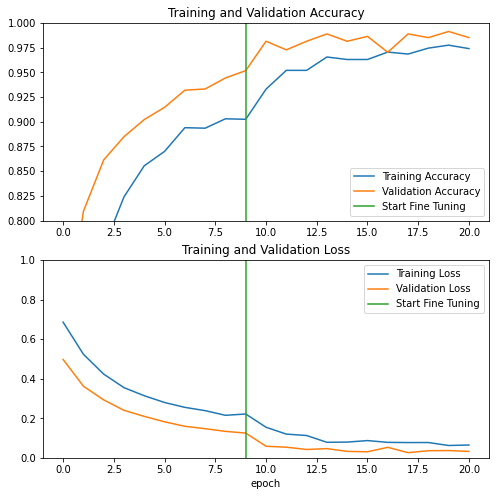

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
acc_custom += history_fine_custom.history['accuracy']
val_acc_custom += history_fine_custom.history['val_accuracy']

loss_custom += history_fine_custom.history['loss']
val_loss_custom += history_fine_custom.history['val_loss']

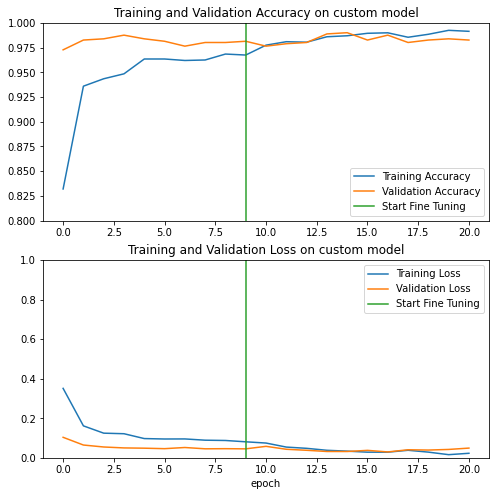

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_custom, label='Training Accuracy')
plt.plot(val_acc_custom, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy on custom model')

plt.subplot(2, 1, 2)
plt.plot(loss_custom, label='Training Loss')
plt.plot(val_loss_custom, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss on custom model')
plt.xlabel('epoch')
plt.show()

#### **=>When train without freeze base model, accuracy is stable and increase to 0.99.**

### Evaluation and prediction

Finally I will verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 45ms/step - loss: 0.0476 - accuracy: 0.9844
Test accuracy : 0.984375


In [ ]:
loss, accuracy = model_custom.evaluate(test_dataset)
print('Test accuracy on custom model :', accuracy)

6/6 [==============================] - 1s 45ms/step - loss: 0.0231 - accuracy: 0.9896
Test accuracy on custom model : 0.9895833134651184


And now I'm all set to use this model to predict if my pet is a cat or dog.

Predictions:
 [1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0]
Labels:
 [1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0]


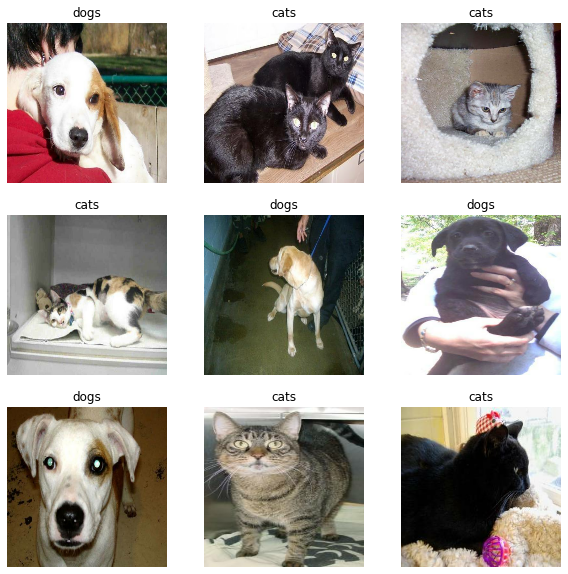

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
